# MNIST example Capsule Network model

First, (re)constructed model is created for the well documented MNIST dataset in order to be able to compare with the foundational paper and other resources online attempting implementations of Capsule Networks.

Once functionality for this is established it can be adapted to our Pneumonia task with the knowledge that the architecture functions should work properly.

In [128]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, layers

from ReadDataCG import train as trainc, test as testc, val as valc
from ReadDataLocal import train as trainl, test as testl, val as vall

## Initialisation and setup

### Hyperparameters

In [129]:
epochs = 12
batch_size = 64

In [130]:
capsule_iterations = 2

num_filters = 256
num_base_mappings = 32
dim_base_capsules = num_filters // num_base_mappings

num_super_capsules = 10
dim_super_capsules = 16

### Util functions

In [131]:
def safe_normalise(vector, axis=1, epsilon=1e-7, keepdims=True):
    norm_squared = tf.reduce_sum(tf.square(vector), axis, keepdims)
    return tf.sqrt(norm_squared + epsilon)  # epsilon added to prevent division by 0

def safe_squash(vector, axis=1, epsilon=1e-7):
    norm_squared = tf.reduce_sum(
        tf.square(vector), 
        axis=axis, 
        keepdims=True
    )
    scalar_factor = norm_squared / (1 + norm_squared)
    
    safe_normalise = tf.sqrt(norm_squared + epsilon)  # epsilon added to prevent division by 0
    unit_vector = vector / safe_normalise
    return scalar_factor * unit_vector


In [132]:
def loss_function(
    vector, 
    reconstructed_image, 
    y, 
    y_image,
    epsilon=1e-7,
    m_plus=0.9,
    m_minus=0.1,
    lambda_=0.5,
    alpha=0.0005,
):
    safe_normal = safe_normalise(vector, axis=-1, keepdims=True)
    prediction = tf.reshape(safe_normal, [-1, num_super_capsules])

    left_margin = tf.square(tf.maximum(0.0, m_plus - prediction))
    right_margin = tf.square(tf.maximum(0.0, prediction - m_minus))

    margin_loss = tf.add(y * left_margin, lambda_ * (1.0 - y) * right_margin)
    margin_loss = tf.reduce_mean(tf.reduce_sum(margin_loss, axis=-1))

    y_image_flat = tf.reshape(y_image, [-1, 784])  #!TODO HARDCODED 28x28 pixels
    reconstruction_loss = tf.reduce_mean(tf.square(y_image_flat - reconstructed_image))

    loss = tf.add(margin_loss, alpha * reconstruction_loss)

    return loss

In [133]:
def get_layer_output_imgsize(input_size: int, kernel_size: int = 9, strides: int = 1):
    return (input_size - kernel_size) // strides

### Loading in the dataset

#### MNIST toy data
This is to build the model first with regular, well-documented matrix multiplication steps and reshapes.
After this is completed, the model can be adapted to the Pneumonia dataset

In [134]:
(X_train, y_train), (X_test , y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train / 255.0
X_train = tf.cast(X_train, dtype=tf.float32)
X_train = tf.expand_dims(X_train, axis=-1)

X_test = X_test / 255.0
X_test = tf.cast(X_test, dtype=tf.float32)
X_test = tf.expand_dims(X_test, axis=-1)

X_train.shape, X_test.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [135]:
cutoff = 256

X_train, y_train = X_train[:cutoff], y_train[:cutoff]
X_test, y_test = X_test[:cutoff], y_test[:cutoff]

#### Process and augment data

In [136]:
n_trainset = X_train.shape[0]
n_testset = X_test.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size=batch_size)

testset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
testset = testset.batch(batch_size=batch_size)

##### Visually inspect data

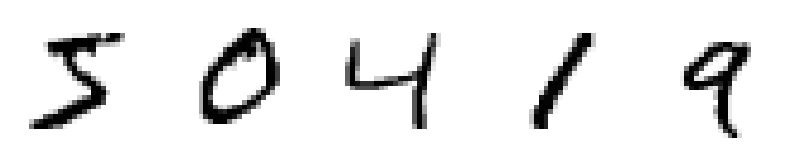

(None, array([5, 0, 4, 1, 9], dtype=uint8))

In [137]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = X_train[index]
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show(), y_train[:n_samples]

## Building the Capsule Network class

In [138]:
class CapsuleNetwork(Model):
    def __init__(
        self, 
        num_filters, 
        num_base_mappings, dim_base_capsules, 
        num_super_capsules, dim_super_capsules, 
        iterations: int = 3,
        kernel_size: int = 9):
        super().__init__()
        self.num_filters = num_filters
        self.num_base_mappings = num_base_mappings
        self.dim_base_capsules = dim_base_capsules
        self.num_super_capsules = num_super_capsules
        self.dim_super_capsules = dim_super_capsules
        self.num_base_capsules = self.num_base_mappings * 6 ** 2

        self.iterations = iterations
        self.kernel_size = kernel_size

        with tf.name_scope("Variables") as scope:
            kernel = [self.kernel_size, self.kernel_size]
            
            self.convolution = layers.Conv2D(self.num_filters, kernel, strides=[1,1], name='ConvolutionLayer', activation='relu')
            self.base_capsule = layers.Conv2D(self.num_base_mappings * self.dim_base_capsules, kernel, strides=[2,2], name="BaseCapsule")
            self.w = tf.Variable(
                tf.random_normal_initializer()(shape=[
                    1, 
                    self.num_base_capsules, self.num_super_capsules, 
                    self.dim_super_capsules, self.dim_base_capsules
                    ]), 
                dtype=tf.float32, 
                name="PoseEstimation", 
                trainable=True)
            
            self.dense_1 = layers.Dense(units = 512, activation='relu')
            self.dense_2 = layers.Dense(units = 1024, activation='relu')
            self.dense_3 = layers.Dense(units = 784, activation='sigmoid', dtype='float32')

    def build(self, input_shape):
        pass

    def squash(self, vector, epsilon=1e-7):
        with tf.name_scope("SafeSquashFunction") as scope:
            norm_squared = tf.reduce_sum(
                tf.square(vector), 
                axis=-1, 
                keepdims=True
            )
            scalar_factor = norm_squared / (1 + norm_squared)
            
            safety_normalise = tf.sqrt(norm_squared + epsilon)
            unit_vector = vector / safety_normalise
            return scalar_factor * unit_vector

    @tf.function
    def call(self, inputs):
        input_x, y = inputs
        # input_x.shape: (None, 28, 28, 1)
        # y.shape: (None, 10)

        x = self.convolution(input_x) # x.shape: (None, 20, 20, 256)
        x = self.base_capsule(x) # x.shape: (None, 6, 6, 256)

        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.num_base_mappings * x.shape[1] * x.shape[2], self.dim_base_capsules)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)


        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((input_x.shape[0], 1152, self.num_super_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.iterations): # self.iterations = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement

        with tf.name_scope("Masking") as scope:
            y = tf.expand_dims(y, axis=-1) # y.shape: (None, 10, 1)
            y = tf.expand_dims(y, axis=1) # y.shape: (None, 1, 10, 1)
            mask = tf.cast(y, dtype=tf.float32) # mask.shape: (None, 1, 10, 1)
            v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)

        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(v_masked, [-1, self.num_super_capsules * self.dim_super_capsules]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)

        return v, reconstructed_image

    @tf.function
    def predict_capsule_output(self, inputs):
        x = self.convolution(inputs) # x.shape: (None, 20, 20, 256)
        x = self.base_capsule(x) # x.shape: (None, 6, 6, 256)

        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.num_base_capsules, self.dim_base_capsules)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)


        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((inputs.shape[0], 1152, self.num_super_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.iterations): # self.iterations = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
        return v

    @tf.function
    def regenerate_image(self, inputs):
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(inputs, [-1, self.num_super_capsules * self.dim_super_capsules]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        return reconstructed_image



### Instantiate

In [139]:
tf.summary.trace_on(graph=True, profiler=True)
model = CapsuleNetwork(
    num_filters=num_filters,
    num_base_mappings=num_base_mappings,
    dim_base_capsules=dim_base_capsules,
    num_super_capsules=num_super_capsules,
    dim_super_capsules=dim_super_capsules,
    iterations=capsule_iterations
)

In [140]:
Optimiser = tf.keras.optimizers.Adam()

### Train

In [141]:
def train(x,y):
    y_one_hot = tf.one_hot(y, depth=num_super_capsules)
    with tf.GradientTape() as tape:
        v, reconstructed_image = model([x, y_one_hot])
        loss = loss_function(v, reconstructed_image, y_one_hot, x)
    grad = tape.gradient(loss, model.trainable_variables)
    Optimiser.apply_gradients(zip(grad, model.trainable_variables))
    return loss

# _ = train(X_train[:32], y_train[:32])

tf.summary.trace_off()

In [142]:
def predict(model, x):
    pred = model.predict_capsule_output(x)
    pred_normed = safe_normalise(pred)
    pred_normed = tf.squeeze(pred_normed, [1])
    return np.argmax(pred_normed, axis=1)[:,0]


In [143]:
checkpoint = tf.train.Checkpoint(model=model)
losses = []
accuracy = []
for i in range(1, epochs+1, 1):

    loss = 0
    with tqdm(total=len(dataset)) as pbar:

        description = "Epoch " + str(i) + "/" + str(epochs)
        pbar.set_description_str(description)

        for X_batch, y_batch in dataset:

            loss += train(X_batch,y_batch)
            pbar.update(1)

        loss /= len(dataset)
        losses.append(loss.numpy())

        training_sum = 0

        print_statement = "Loss :" + str(loss.numpy()) + " Evaluating Accuracy ..."
        pbar.set_postfix_str(print_statement)

        for X_batch, y_batch in dataset:
            training_sum += sum(predict(model, X_batch)==y_batch.numpy())
        accuracy.append(training_sum/n_trainset)

        print_statement = "Loss :" + str(loss.numpy()) + " Accuracy :" + str(accuracy[-1])

        pbar.set_postfix_str(print_statement)

Epoch 12/12: 100%|██████████| 4/4 [00:24<00:00,  6.02s/it, Loss :0.030238086 Accuracy :0.85546875]   


In [144]:
test_sum = 0
for X_batch, y_batch in testset:
    test_sum += sum(predict(model, X_batch)==y_batch.numpy())
print(test_sum/n_testset)

0.61328125
